In [1]:
#importing torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#to check work directory
import os

In [2]:
#loading csv file
training_frame = pd.read_csv('/content/drive/MyDrive/kaggle_data/train.csv')


In [3]:
#Setting the Seed and Random Value

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [4]:
#Listing the directories

base_dir = '/content/drive/MyDrive/kaggle_data/train'
train_dir = '/content/drive/MyDrive/kaggle_data/train'
test_dir = '/content/drive/MyDrive/kaggle_data/test'

In [5]:
os.listdir(train_dir)[:5]

['2168.png', '711.png', '2169.png', '917.png', '597.png']

In [6]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.png'))
test_list = glob.glob(os.path.join(test_dir, '*.png'))

In [7]:
#Checking length of training data
len(train_list)

2190

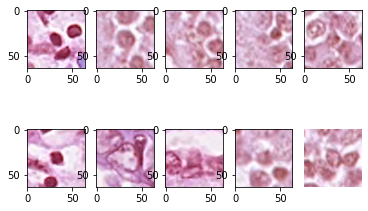

In [8]:
#Cheking the dataset and plotting some images

from PIL import Image
random_idx = np.random.randint(1,2190,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [9]:
#Splitting train data for training and validation

from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [10]:
#Image Augumentation

train_transforms =  transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])


In [11]:
#Loading the dataset

class dataset(torch.utils.data.Dataset):

    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
       
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label= training_frame.iloc[idx, 1]
        
        if label == 'Connective':
            label=0
        elif label == 'Cancer':
            label=1
        elif label == 'Immune':
            label=2
        elif label == 'Normal':
            label=3
            
        return img_transformed,label

In [12]:
#Using torchvision

train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=100, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=100, shuffle=True)

In [14]:
print(len(val_data), len(val_loader))

438 5


In [15]:
#check shape of image
train_data[0][0].shape

torch.Size([3, 64, 64])

In [16]:
# Building model 4 convolutional and 3 fully connected layers

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        #Input Shape(100,3,64,64)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3, padding=1),
            #Shape(100,8,64,64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #Shape(100,8,64,64)
            nn.MaxPool2d(2)
            #Shape(100,8,32,32)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            #Shape(100,16,32,32)
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)
            #Shape(100,16,16,16)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128,512, kernel_size=3, padding=1),
            #Shape(100,32,16,16)
            nn.BatchNorm2d(512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)
            #Shape(100,32,8,8)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            #Shape(100,64,8,8)
            nn.BatchNorm2d(512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)
            #Shape(100,64,4,4)
        )

        self.flatten = nn.Flatten()        
        self.fc1 = nn.Linear(512*4*4,1024)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024,512)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(512,4)
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = self.layer5(out)
        out = self.flatten(out)
        out=self.fc1(out)
        out=self.relu1(out)
        out = self.fc2(out)
        out=self.relu2(out)
        out = self.fc3(out)
        return out

In [17]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Co

In [18]:
#Setting optimizer and loss function
optimizer = optim.Adam(params = model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [19]:
#Network training

epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        # print ("Output:",output)
        loss = criterion(output, label)
        #print ("Loss:",loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.2818376123905182, train loss : 1.3911552429199219
Epoch : 1, val_accuracy : 0.5243157744407654, val_loss : 1.0561305284500122
Epoch : 2, train accuracy : 0.3050427734851837, train loss : 1.3269855976104736
Epoch : 2, val_accuracy : 0.4622105360031128, val_loss : 1.110784649848938
Epoch : 3, train accuracy : 0.3025640845298767, train loss : 1.3136624097824097
Epoch : 3, val_accuracy : 0.4594736695289612, val_loss : 1.1984120607376099
Epoch : 4, train accuracy : 0.32448717951774597, train loss : 1.3065180778503418
Epoch : 4, val_accuracy : 0.3794737160205841, val_loss : 1.1968194246292114
Epoch : 5, train accuracy : 0.3558119535446167, train loss : 1.3001371622085571
Epoch : 5, val_accuracy : 0.4762105345726013, val_loss : 1.14580500125885
Epoch : 6, train accuracy : 0.3781623840332031, train loss : 1.2939668893814087
Epoch : 6, val_accuracy : 0.3576841950416565, val_loss : 1.197003960609436
Epoch : 7, train accuracy : 0.3554273545742035, train loss : 1.2899

In [20]:
#Check our predictions on test data
model.eval()
pred_list=[]
with torch.no_grad():
    for data, label in test_loader:
        #print(label)
        data = data.to(device)
        output = model(data)
        #print (output.size)
        
       
        pred_list.extend(list(output.argmax(dim=1, keepdim=True).storage()))



In [21]:

from collections   import Counter
Counter(pred_list)

Counter({0: 108, 1: 19, 2: 254, 3: 19})

In [22]:
#Convert output to appropriate label and write to csv file for submission

dic = { 0 :'Connective', 1 :'Cancer', 2 :'Immune', 3 :'Normal'}
real_output = [dic.get(n, n) for n in pred_list]
d = {'Id': np.arange(10001, 10401), 'Type': real_output}
df = pd.DataFrame(data=d)
df.to_csv("results.csv", index=False)